In [15]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

In [16]:
data = yf.download(['^VIX', 'SPY'], start='2000-01-01', end='2023-12-31')['Adj Close']

# Calculate Moving Averages for VIX
data['MA50_VIX'] = data['^VIX'].rolling(window=50).mean()
data['MA100_VIX'] = data['^VIX'].rolling(window=100).mean()

# Calculate RSI for SPY
delta = data['SPY'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))

# Calculate MACD for SPY
exp1 = data['SPY'].ewm(span=12, adjust=False).mean()
exp2 = data['SPY'].ewm(span=26, adjust=False).mean()
data['MACD'] = exp1 - exp2
data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()

data['crossover'] = np.where(data['MA50_VIX'] > data['MA100_VIX'], 1, np.where(data['MA50_VIX'] < data['MA100_VIX'], -1, 0))

# Incorporate RSI and MACD into signals
data['RSI_signal'] = np.where(data['RSI'] > 70, -1, np.where(data['RSI'] < 30, 1, 0))
data['MACD_signal'] = np.where(data['MACD'] > data['Signal_Line'], 1, -1)

# Define weights for each signal
weights = {
    'crossover': 0.4,
    'RSI_signal': 0.2,
    'MACD_signal': 0.4
}

# Calculate the weighted combined signal
data['weighted_signal'] = (data['crossover'] * weights['crossover'] +
                           data['RSI_signal'] * weights['RSI_signal'] +
                           data['MACD_signal'] * weights['MACD_signal'])

# Define thresholds for the final signal based on the weighted combined signal
threshold_positive = 0.2
threshold_negative = -0.2

data['final_signal'] = np.where(data['weighted_signal'] > threshold_positive, 1,
                                np.where(data['weighted_signal'] < threshold_negative, -1, 0))

print(data[['final_signal']].tail())


[*********************100%%**********************]  2 of 2 completed

Ticker      final_signal
Date                    
2023-12-22            -1
2023-12-26            -1
2023-12-27            -1
2023-12-28            -1
2023-12-29            -1


[*********************100%%**********************]  13 of 13 completed


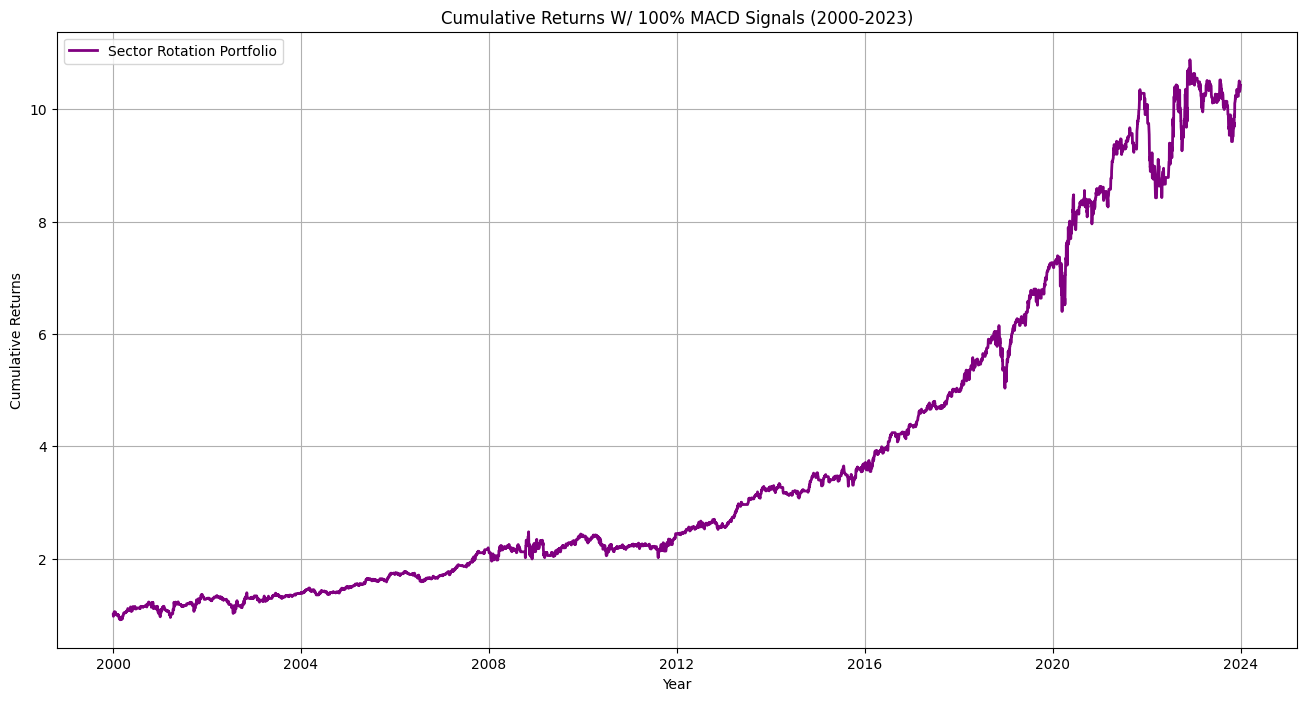

In [17]:
# Define the tickers for the assets
assets = {
    'S&P': 'SPY',
    'Communication Services': 'XLC',
    'Consumer Discretionary': 'XLY',
    'Consumer Staples': 'XLP',
    'Energy': 'XLE',
    'Financials': 'XLF',
    'Health Care': 'XLV',
    'Industrials': 'XLI',
    'Materials': 'XLB',
    'Technology': 'XLK',
    'Utilities': 'XLU',
    'Gold': 'GLD',
    'Bonds': 'AGG',
}

# Download historical data for the assets
asset_data = yf.download(list(assets.values()), start='2000-01-01', end='2023-12-31')['Adj Close']

# Initialize the SectorRotationPortfolio with zero exposure initially
SectorRotationPortfolio = pd.DataFrame(index=asset_data.index, columns=asset_data.columns)
SectorRotationPortfolio[:] = 0

bullish_weights = {
    'XLC': 0.0,
    'XLY': 0.2,
    'XLK': 0.6,
    'XLF': 0.0,
    'XLI': 0.1,
    'XLB': 0.1,
    'XLP': 0, 'XLU': 0, 'XLV': 0, 'GLD': 0, 'AGG': 0,
}

bearish_weights = {
    'XLU': 0.25, 'XLP': 0.45, 'XLV': 0.30, 'GLD': 0, 'AGG': 0
    , 'XLB': 0, 'XLI': 0, 'XLF': 0, 'XLC': 0, 'XLY': 0, 'XLK': 0
}

neutral_weights = {ticker: 1/len(assets) for ticker in assets if assets[ticker] not in ['GLD', 'AGG']}

# Portfolio allocation based on signals
for date, signal in data['final_signal'].items():
    if signal == 1:  # Bullish signal
        for asset, weight in bullish_weights.items():
            SectorRotationPortfolio.loc[date, asset] = weight
    elif signal == -1:  # Bearish signal
        for asset, weight in bearish_weights.items():
            SectorRotationPortfolio.loc[date, asset] = weight
    else:  # Neutral signal
        for asset, weight in neutral_weights.items():
            SectorRotationPortfolio.loc[date, asset] = weight

# Calculate daily and cumulative returns
SectorRotationPortfolio_returns = (SectorRotationPortfolio.shift() * asset_data.pct_change()).sum(axis=1)
SectorRotationPortfolio_cumulative_returns = (1 + SectorRotationPortfolio_returns).cumprod()

plt.figure(figsize=(16, 8))
plt.plot(SectorRotationPortfolio_cumulative_returns.index, SectorRotationPortfolio_cumulative_returns, label='Sector Rotation Portfolio', color='purple', linewidth=2)
plt.title('Cumulative Returns W/ 100% MACD Signals (2000-2023)')
plt.xlabel('Year')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
annual_return_aggressive_tech = SectorRotationPortfolio_returns.mean() * 252

annual_volatility_aggressive_tech = SectorRotationPortfolio_returns.std() * np.sqrt(252)

sharpe_ratio_aggressive_tech = annual_return_aggressive_tech / annual_volatility_aggressive_tech

def calculate_max_drawdown(cumulative_returns):
    roll_max = cumulative_returns.cummax()
    daily_drawdown = cumulative_returns / roll_max - 1.0
    max_drawdown = daily_drawdown.min()
    return max_drawdown

max_drawdown_aggressive_tech = calculate_max_drawdown(SectorRotationPortfolio_cumulative_returns)

In [19]:
# Benchmark Portfolio Construction
benchmark_weights = {'SPY': 0.6, 'AGG': 0.4}

benchmark_returns = asset_data[['SPY', 'AGG']].pct_change()
benchmark_portfolio_returns = benchmark_returns['SPY'] * benchmark_weights['SPY'] + benchmark_returns['AGG'] * benchmark_weights['AGG']

annual_return_benchmark = benchmark_portfolio_returns.mean() * 252

benchmark_cumulative_returns = (1 + benchmark_portfolio_returns).cumprod()

sharpe_ratio_benchmark = annual_return_benchmark / (benchmark_portfolio_returns.std() * np.sqrt(252))

max_drawdown_benchmark = calculate_max_drawdown(benchmark_cumulative_returns)

In [20]:
# Equally Weighted Portfolio Construction
all_assets_returns = asset_data.pct_change()

num_assets = len(assets)
equal_weights = 1 / num_assets
equally_weighted_returns = all_assets_returns.mean(axis=1) * equal_weights

equally_weighted_cumulative_returns = (1 + equally_weighted_returns).cumprod()

all_assets_returns = asset_data.pct_change()

equally_weighted_returns = all_assets_returns.mean(axis=1)

annual_return_equally_weighted = equally_weighted_returns.mean() * 252

annual_volatility_equally_weighted = equally_weighted_returns.std() * np.sqrt(252)

sharpe_ratio_equally_weighted = annual_return_equally_weighted / annual_volatility_equally_weighted

equally_weighted_cumulative_returns = (1 + equally_weighted_returns).cumprod()
max_drawdown_equally_weighted = calculate_max_drawdown(equally_weighted_cumulative_returns)

equally_weighted_cumulative_returns = (1 + equally_weighted_returns).cumprod()


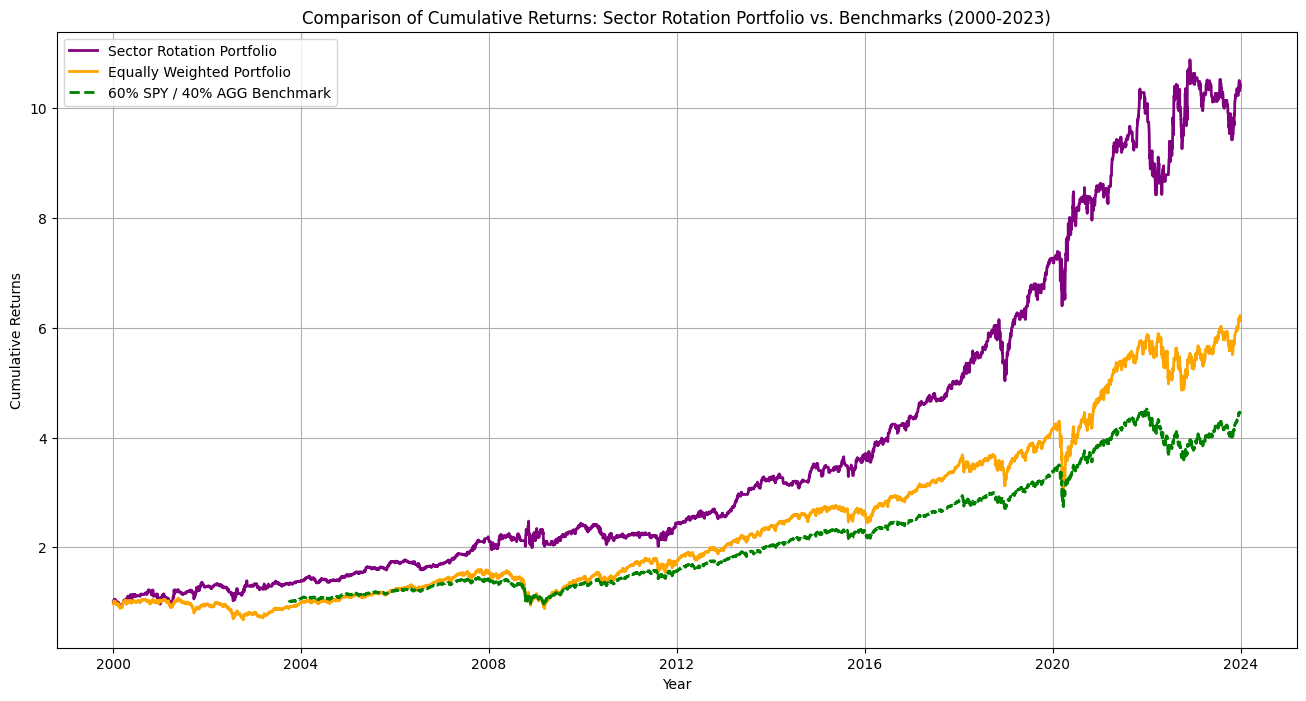

In [21]:
# Plot the performance of all three portfolios
plt.figure(figsize=(16, 8))
plt.plot(SectorRotationPortfolio_cumulative_returns.index, SectorRotationPortfolio_cumulative_returns, label='Sector Rotation Portfolio', color='purple', linewidth=2)
plt.plot(equally_weighted_cumulative_returns.index, equally_weighted_cumulative_returns, label='Equally Weighted Portfolio', color='orange', linestyle='-', linewidth=2)
plt.plot(benchmark_cumulative_returns.index, benchmark_cumulative_returns, label='60% SPY / 40% AGG Benchmark', color='green', linestyle='--', linewidth=2)

plt.title('Comparison of Cumulative Returns: Sector Rotation Portfolio vs. Benchmarks (2000-2023)')
plt.xlabel('Year')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()


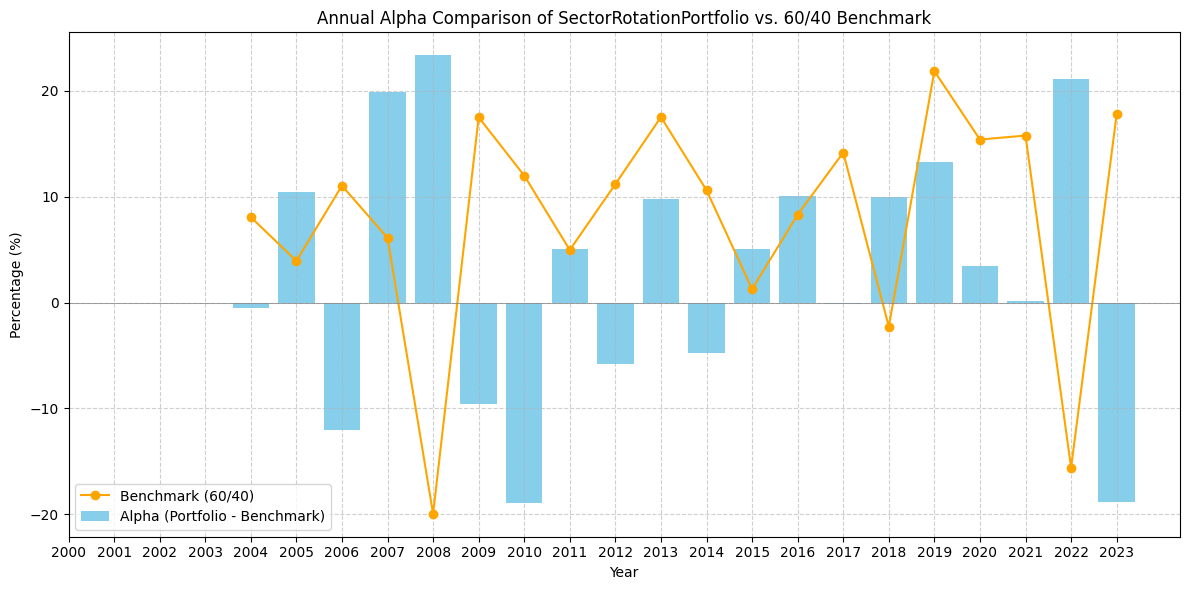

In [22]:
portfolio_daily_returns = (SectorRotationPortfolio.shift() * asset_data.pct_change()).sum(axis=1)

benchmark_weights = {'SPY': 0.6, 'AGG': 0.4}

benchmark_returns = asset_data[['SPY', 'AGG']].pct_change()
benchmark_daily_returns = benchmark_returns['SPY'] * benchmark_weights['SPY'] + benchmark_returns['AGG'] * benchmark_weights['AGG']

# Calculate cumulative returns and then annualize them
portfolio_cumulative_returns = (1 + portfolio_daily_returns).cumprod()
benchmark_cumulative_returns = (1 + benchmark_daily_returns).cumprod()

# Resample to annual returns
portfolio_annual_returns = portfolio_cumulative_returns.resample('Y').last().pct_change()
benchmark_annual_returns = benchmark_cumulative_returns.resample('Y').last().pct_change()

# Compute the Alpha for each year (Portfolio - Benchmark)
alpha_annual = portfolio_annual_returns - benchmark_annual_returns

# Convert the annual returns to percentage
portfolio_annual_returns *= 100
benchmark_annual_returns *= 100
alpha_annual *= 100

years = alpha_annual.index.year
df_plot = pd.DataFrame({
    'Alpha': alpha_annual.values,
    'Benchmark': benchmark_annual_returns.values
}, index=years)

# Plotting the Alpha
plt.figure(figsize=(12, 6))
plt.bar(df_plot.index, df_plot['Alpha'], color='skyblue', label='Alpha (Portfolio - Benchmark)')
plt.plot(df_plot.index, df_plot['Benchmark'], color='orange', label='Benchmark (60/40)', marker='o')

plt.xlabel('Year')
plt.ylabel('Percentage (%)')
plt.title('Annual Alpha Comparison of SectorRotationPortfolio vs. 60/40 Benchmark')
plt.axhline(0, color='gray', linewidth=0.5)  # Zero line for reference
plt.xticks(df_plot.index)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [23]:
print("Performance Metrics Comparison:\n")

print("60/40 Benchmark Metrics:")
print(f"Annual Return: {annual_return_benchmark * 100:.2f}%")
print(f"Annual Volatility: {benchmark_portfolio_returns.std() * np.sqrt(252) * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_benchmark:.2f}")
print(f"Max Drawdown: {max_drawdown_benchmark * 100:.2f}%\n")

print("Equally Weighted Portfolio Metrics:")
print(f"Annual Return: {annual_return_equally_weighted * 100:.2f}%")
print(f"Annual Volatility: {annual_volatility_equally_weighted * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_equally_weighted:.2f}")
print(f"Max Drawdown: {max_drawdown_equally_weighted * 100:.2f}%\n")

print("Sector Rotation Portfolio Metrics:")
print(f"Annual Return: {annual_return_aggressive_tech * 100:.2f}%")
print(f"Annual Volatility: {annual_volatility_aggressive_tech * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_aggressive_tech:.2f}")
print(f"Max Drawdown: {max_drawdown_aggressive_tech * 100:.2f}%\n")



Performance Metrics Comparison:

60/40 Benchmark Metrics:
Annual Return: 8.07%
Annual Volatility: 11.49%
Sharpe Ratio: 0.70
Max Drawdown: -34.70%

Equally Weighted Portfolio Metrics:
Annual Return: 8.97%
Annual Volatility: 16.43%
Sharpe Ratio: 0.55
Max Drawdown: -44.33%

Sector Rotation Portfolio Metrics:
Annual Return: 10.99%
Annual Volatility: 15.54%
Sharpe Ratio: 0.71
Max Drawdown: -24.80%



In [24]:
combined_returns = pd.DataFrame({
    'AggressiveTech': SectorRotationPortfolio_returns,
    'Benchmark': benchmark_portfolio_returns
}).dropna()


In [25]:
combined_returns['AggressiveTech'] = pd.to_numeric(combined_returns['AggressiveTech'], errors='coerce')

# Drop any rows that may have NaNs after conversion
combined_returns = combined_returns.dropna()


In [26]:
covariance = np.cov(combined_returns['AggressiveTech'], combined_returns['Benchmark'])[0, 1]
variance = np.var(combined_returns['Benchmark'])

beta_aggressive_tech = covariance / variance

# Calculate alpha using the calculated beta and annualized returns
risk_free_rate = 0.0
expected_market_return = combined_returns['Benchmark'].mean() * 252  # Annualize the mean return
alpha_aggressive_tech = annual_return_aggressive_tech - (annual_return_benchmark)


print(f'Beta of SectorRotationPortfolio: {beta_aggressive_tech}')
print(f'Alpha of SectorRotationPortfolio: {alpha_aggressive_tech}')


Beta of SectorRotationPortfolio: 0.852164416534604
Alpha of SectorRotationPortfolio: 0.029214945674631718


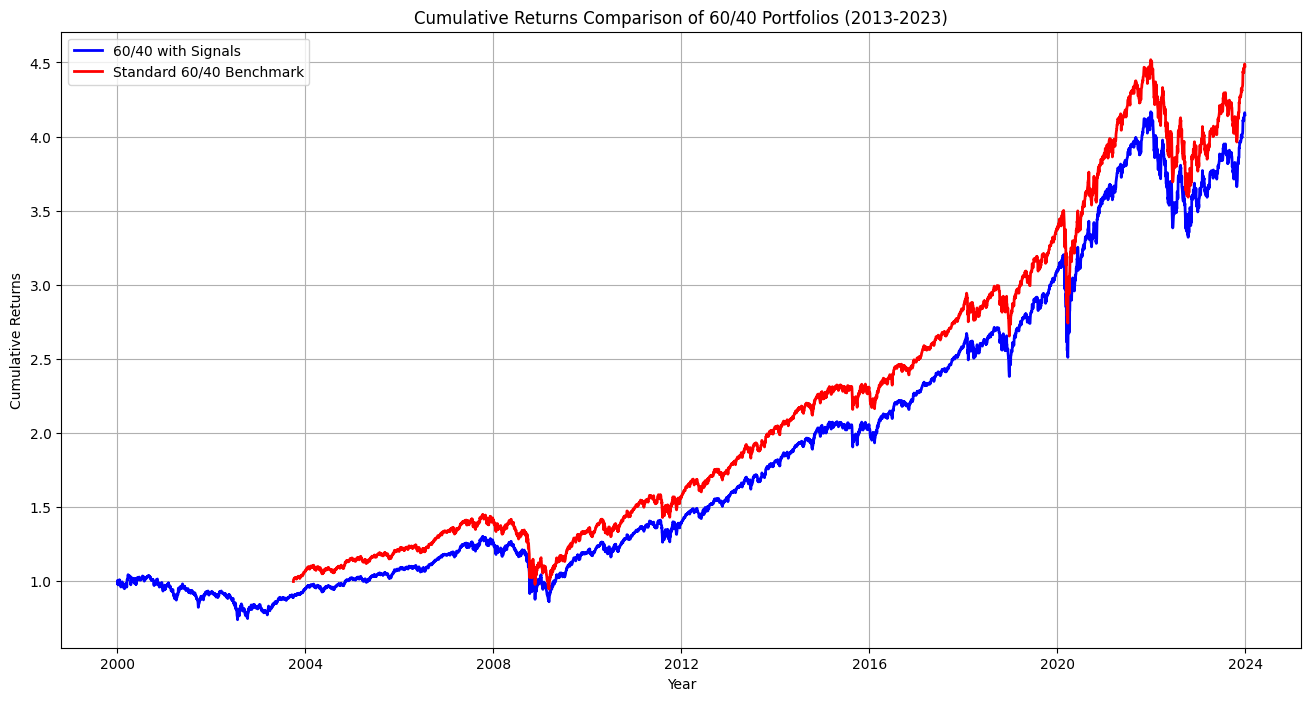

In [27]:
# Signal Algorithm Applied to 60 / 40 Portfolio

base_weights = {'SPY': 0.6, 'AGG': 0.4}

SignalBased6040Portfolio = pd.DataFrame(index=asset_data.index, columns=['SPY', 'AGG'])
SignalBased6040Portfolio[:] = 0

# Portfolio allocation based on signals for a 60/40 structure
for date, signal in data['final_signal'].items():
    if signal == 1:  # Bullish signal, increase stock weight
        SignalBased6040Portfolio.loc[date, 'SPY'] = 0.70  # Increase SPY to 70%
        SignalBased6040Portfolio.loc[date, 'AGG'] = 0.30  # Decrease AGG to 30%
    elif signal == -1:  # Bearish signal, increase bond weight
        SignalBased6040Portfolio.loc[date, 'SPY'] = 0.5  # Decrease SPY to 50%
        SignalBased6040Portfolio.loc[date, 'AGG'] = 0.5  # Increase AGG to 50%
    else:  # Neutral signal, retain the original 60/40 weights
        SignalBased6040Portfolio.loc[date, 'SPY'] = base_weights['SPY']
        SignalBased6040Portfolio.loc[date, 'AGG'] = base_weights['AGG']

SignalBased6040Portfolio_returns = (SignalBased6040Portfolio.shift() * asset_data[['SPY', 'AGG']].pct_change()).sum(axis=1)
SignalBased6040Portfolio_cumulative_returns = (1 + SignalBased6040Portfolio_returns).cumprod()

plt.figure(figsize=(16, 8))
plt.plot(SignalBased6040Portfolio_cumulative_returns.index, SignalBased6040Portfolio_cumulative_returns, label='60/40 with Signals', color='blue', linewidth=2)
plt.plot(benchmark_cumulative_returns.index, benchmark_cumulative_returns, label='Standard 60/40 Benchmark', color='red', linewidth=2)
plt.title('Cumulative Returns Comparison of 60/40 Portfolios (2013-2023)')
plt.xlabel('Year')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()


[*********************100%%**********************]  10 of 10 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['XLC']: YFChartError("%ticker%: Data doesn't exist for startDate = 1199163600, endDate = 1388466000")


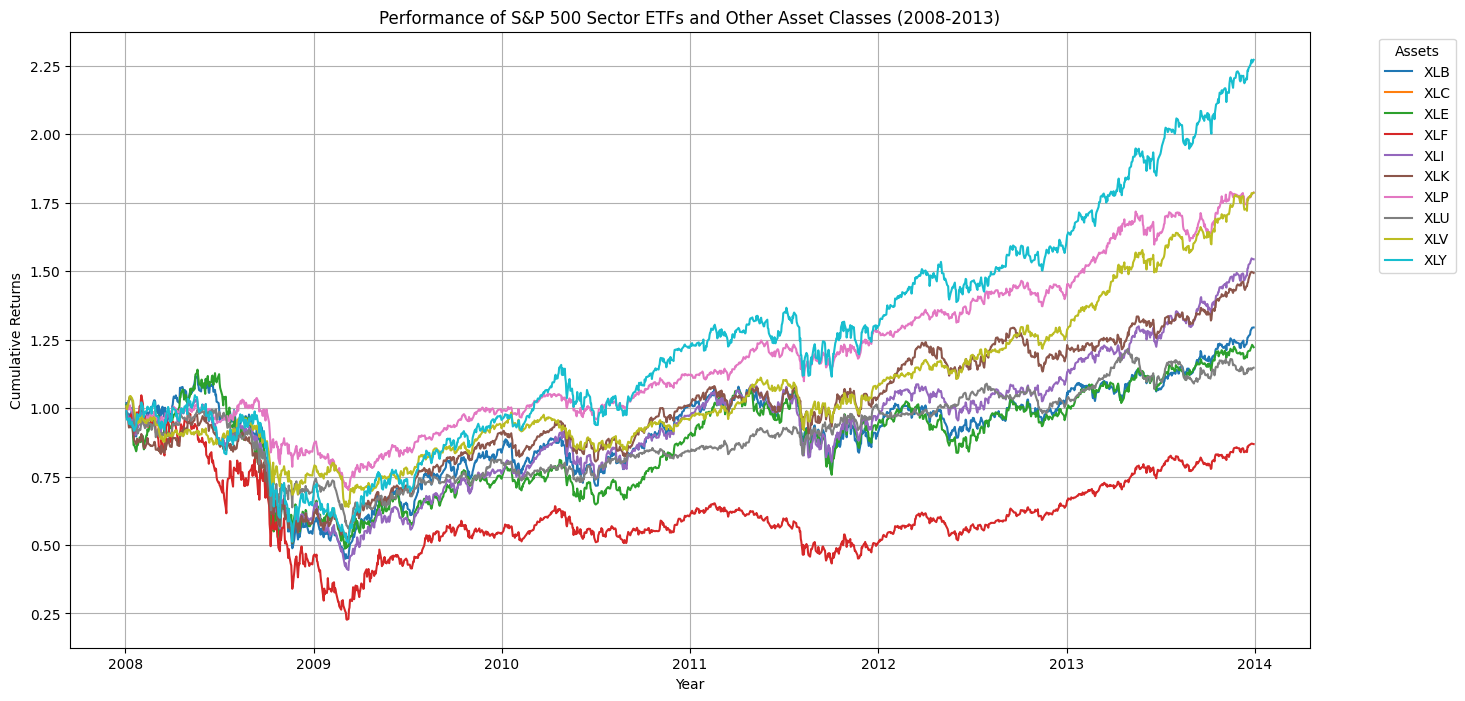

In [28]:
assets = {
    'Communication Services': 'XLC',
    'Consumer Discretionary': 'XLY',
    'Consumer Staples': 'XLP',
    'Energy': 'XLE',
    'Financials': 'XLF',
    'Health Care': 'XLV',
    'Industrials': 'XLI',
    'Materials': 'XLB',
    'Technology': 'XLK',
    'Utilities': 'XLU',
}

data = yf.download(list(assets.values()), start='2008-01-01', end='2013-12-31')['Adj Close']

cumulative_returns = (data.pct_change() + 1).cumprod()

plt.figure(figsize=(16, 8))
for column in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[column], label=column)

plt.title('Performance of S&P 500 Sector ETFs and Other Asset Classes (2008-2013)')
plt.xlabel('Year')
plt.ylabel('Cumulative Returns')
plt.legend(title='Assets', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()